# Strategy Testing

## Strategy Description

### What is Granger?

### Iteration 1
- Using rolling single pair granger causality tests to determine which tokens are causal at any one point in time
- At that point, fit a multivaraite rolling granger causality to predict the next data point
- Trade with size determined by goodness of fit and predicted change 

- Vary across different time frames
- Keep window size fixed (1hr for minute data, 24 hr for hour data, 30 days for daily data)
#
___

In [13]:
# imports
import os
import sys
import logging
import warnings
import logging
from itertools import combinations

# add the parent directory to the path
sys.path.append(os.path.dirname(os.path.abspath('')))
from src.data.data_processor import DataProcessor
from src.visualization.causality_viz import CausalityVisualizer
from src.analysis.causality import CausalityAnalyzer
from src.analysis.granger_causality import AutomatedGrangerAnalyzer
from src.analysis.stationarity import StationarityTester
from src.analysis.outliers import OutlierAnalyzer
from src.analysis.time_varying_granger import run_tvgc_analysis
from src.utils.helpers import calculate_returns
from src.utils.load_data import load_parquet_data

from scipy import stats
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR


### 1. Load Data

In [272]:
data_dir = "../data/processed"
interval = "1h"

returns, prices = load_parquet_data(data_dir=data_dir, interval=interval)
log_returns = pd.DataFrame({key: returns[key]["log_returns"] for key in returns.keys()}).dropna()

2025-01-09 16:12:53 - INFO - Initializing analyzer with data directory: ../data/processed
2025-01-09 16:12:53 - INFO - Starting data loading process...
2025-01-09 16:12:53 - INFO - Looking for parquet files in: c:\ClassPy\week14proj\CryptoCausality\data\processed
2025-01-09 16:12:53 - INFO - Found 6 parquet files
2025-01-09 16:12:53 - INFO - Processing file for ADAUSDT
2025-01-09 16:12:53 - INFO - Loaded 8201 rows for ADAUSDT
2025-01-09 16:12:53 - INFO - Calculating simple returns for ADAUSDT
2025-01-09 16:12:53 - INFO - Calculating price difference for ADAUSDT
2025-01-09 16:12:53 - INFO - Calculating log returns for ADAUSDT
2025-01-09 16:12:53 - INFO - Successfully processed ADAUSDT
2025-01-09 16:12:53 - INFO - Processing file for BNBUSDT
2025-01-09 16:12:53 - INFO - Loaded 8201 rows for BNBUSDT
2025-01-09 16:12:53 - INFO - Calculating simple returns for BNBUSDT
2025-01-09 16:12:53 - INFO - Calculating price difference for BNBUSDT
2025-01-09 16:12:53 - INFO - Calculating log returns f

In [16]:
def plot_time_series_data(data, column="close", title=None, symbol=None):
    if symbol != None: 
        fig = px.line(data[f'{symbol}USDT'], x="timestamp", y=column, title=f"{symbol} Close Price", height=500)  
        fig.show()
    else: 
        for symbol in data.keys():
            fig = px.line(data[symbol], x="timestamp", y=column, title=f"{symbol} Close Price", height=300)  
            fig.show()
    

plot_time_series_data(prices, column="close", title="Close Price")

### 2. Load Causal test data

**How results are used and interpreted**

- Time varying granger causality results for each pair in a single granger rolling model. Each model is run on 10 days of minute data with a rolling window of 300 minutes (5 hours) and a max lag of 100 minutes. 
- Gives the f-stat and p-value for each timestep which indicates the effectiveness of a multivariate OLS vs an autoregressive model over the window specified. 
- At each timestep, we should see which tokens are significant (p-value<0.5) and use them in a new multivariate VAR model to predict the next value of the target variable. 

*(Admittedly, the VAR model seems superior and should be used in isolation on a rolling basis but the impact of only using bivariate granger to determine the VAR variables may also be of interest. Both should be compared)*

**Issues**

- Only 10 days of data for initial test due to large computational requirement of rolling granger


**Assumptions**

To reduce the computational burden, a couple of assumptions are made...
- max lag: window should be restrained to 10: 1. it seems highly unlikely that there would be any value in data more than 10 minutes old. 2. Although in prior experimentation it is seen that upto a lag of 60 may be significant, lags below 10 also show high significance in comparison and so should equally produce good returns if the strategy is profitable. *Further lag analysis in future would be used if a MVP can be produced.*
- rolling window: This window should be balanced to control computational burden and the information included in training each prediction. For minute data, a window of 5 hours (300 min) seems sensible to capture emerging patterns. *A further analysis varying this should be conducted in future.*


In [18]:
# ANALYSIS VARS
TOKEN = "BTCUSDT"
INTERVAL = "1h"
RESULTS_DIR = "../results"

### Interpretation
- It appears that there are windows of causality between smaller tokens and BTC, particularly for ETH. All tokens however have high causality at times and display significant results > 10% of the time. 
- ADA and ETH seem to have the largest average windows of causality of 24 and 27 minutes respectively. 
- Question: is causality just a reflection of momentum (one strong aspect of crypto). 1. If BTC is an AR progress, then momentum is reflected in this (lagged rise => continuted rise) but do other tokens acutally add anything or just also give momentum during trend and uncorrelated elsewhere.

In [19]:
# trading strategy based off of granger causality
strategy = pd.DataFrame(index=prices[TOKEN].index)
strategy[TOKEN] = log_returns[TOKEN].cumsum()

# calculate signals
strategy["signal"] = 0
strategy["signal"].loc[predictions.index] = predictions["pred"].apply(lambda x: 1 if x > 0 else -1)

# calcualte returns
strategy["returns"] = log_returns[TOKEN] * strategy["signal"].shift(1)
strategy["cumulative_returns"] = strategy["returns"].cumsum()
strategy[[TOKEN, "cumulative_returns"]].plot()

NameError: name 'predictions' is not defined

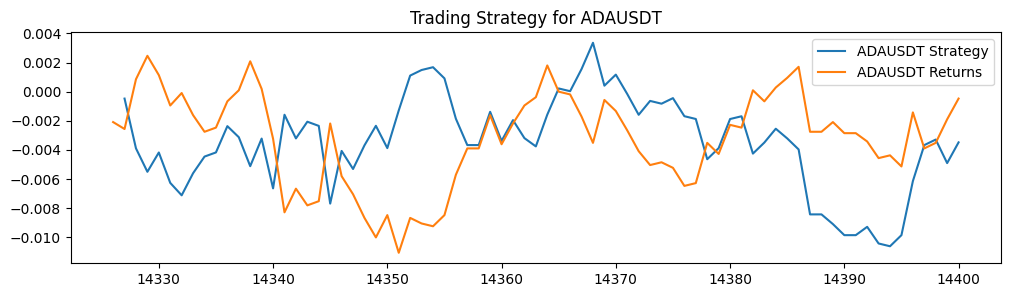

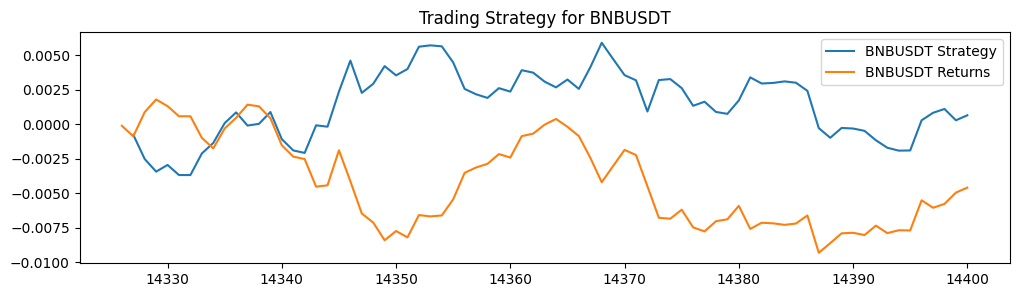

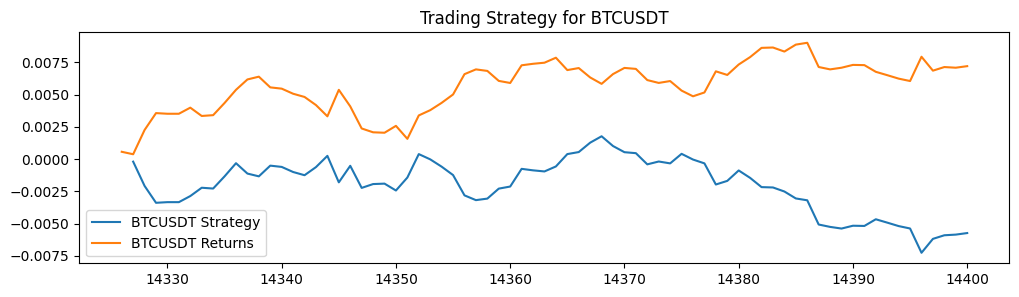

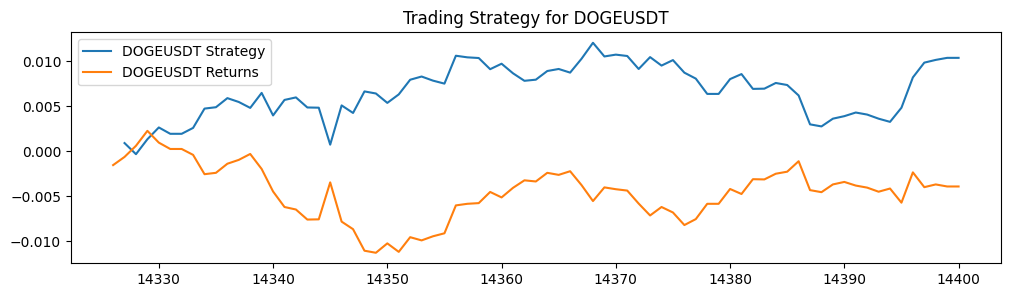

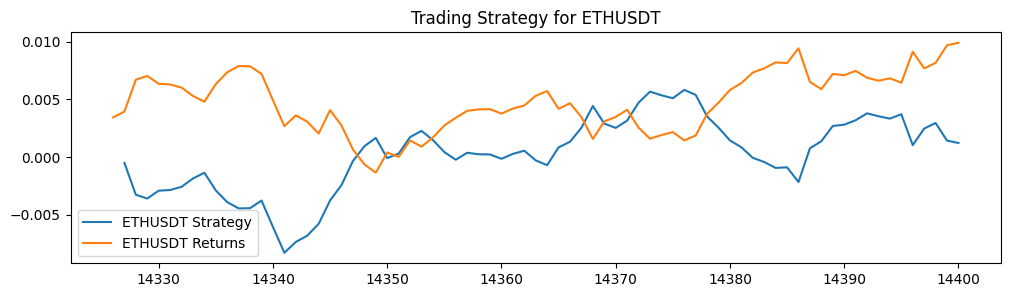

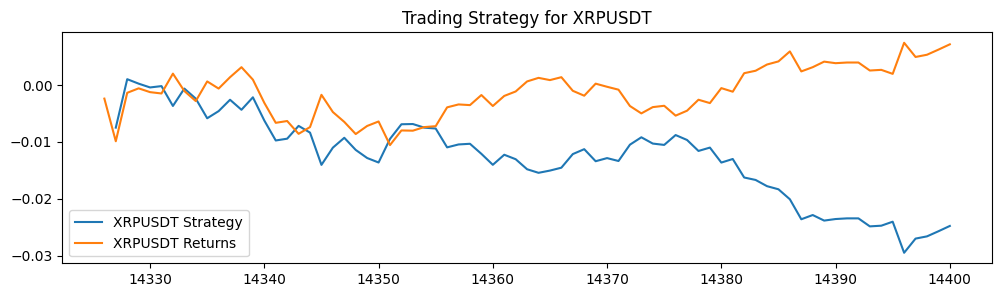

In [186]:
# Plot the results for a simple strategy
for token in log_returns.columns:
    predictions = result_dict[token]['preds']
    stat_results = result_dict[token]['stats']
    # trading strategy based off of granger causality
    strategy = pd.concat([log_returns[token], predictions, stat_results], axis=1)
    strategy = strategy.dropna()
    # calculate signals
    strategy["signal"] = 0
    strategy["signal"] = strategy["pred"].apply(lambda x: 1 if x > 0 else -1)

    # calcualte returns
    strategy["returns"] = strategy[token] * strategy["signal"].shift(1)
    strategy["cumulative_returns"] = strategy["returns"].cumsum()

    # plot results
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(strategy["cumulative_returns"], label=f"{token} Strategy") 
    ax.plot(strategy[token].cumsum(), label=f"{token} Returns")
    ax.set_title(f"Trading Strategy for {token}")
    ax.legend()

### **Reflection**

- the model seems to work but the VAR disagrees with the granger causality in many places. (1257 values are not significant out of the 2019 predicted as significant by bi-granger)
- going to give up on this and do a rolling VAR with every coin, every time-step. 
- VAR lets you pull out the prediction for all variables at once - a trick to speed up calculations is to fit once, pull out all variable predictions. 
- Do we want any exogenous variables? 

*Next Step*

- We created a faster time-varying multi var predictor with a few key features:
    - multithreading.
    - jump fitting where a model is fit every n timesteps and then used to forecast for the next n timesteps such that there is a forecast for every increment of data but a model fit less frequently.
    - saving result frequently and loading where necessary. 

> Results from the updated model are shown next

**TESTS RUN**

1. 1min data for the period 01-09-2024 : 01-01-2025 (3 months)
    - Max lag = 10
    - Window = 300
    - Fit frequency = 5

2. 1h data for the period 2023-01-01 : 2025-01-01 (2 years)
    - Max lag = 12
    - Window = 120 (5 days)
    - Fit frequency = 1

3. 1d data for the period 2020-01-01 : 2025-01-01 (5 years)
    - Max lag = 10
    - Window = 100
    - Fit frequency = 1



In [20]:
# loading in the results data from database
import sqlite3

def load_from_db(tokens, db_file="../results/results.db"):
    conn = sqlite3.connect(db_file)
    result_dict = {}
    lag_order = pd.read_sql("SELECT * FROM lag_order", conn, index_col='timestamp')
    result_dict['lag_order'] = lag_order
    for token in tokens:
        stats = pd.read_sql(f"SELECT * FROM {token}_stats", conn, index_col='timestamp')
        preds = pd.read_sql(f"SELECT * FROM {token}_preds", conn, index_col='timestamp')
        # Convert strings back to lists after loading
        preds['significant_tokens'] = preds['significant_tokens']
        result_dict[token] = {'stats': stats, 'preds': preds}
    conn.close()
    return result_dict


In [47]:
# load results
results_file_1m = "../results/1m/1m_results.db"
results_file_1h = "../results/1h/1h_results.db"
results_file_1d = "../results/1d/1d_results.db"
tokens = log_returns.columns

# results_1m = load_from_db(tokens, db_file=results_file_1m)
results_1h = load_from_db(tokens, db_file=results_file_1h)
# results_1d = load_from_db(tokens, db_file=results_file_1d)

# separate and prepare results data
def prepare_db_results(results_dict: dict): 
    lag_order = results_dict['lag_order'].dropna()
    lag_order = lag_order[lag_order['lag_order']!=0]

    results = {}
    for token in results_dict.keys():
        if token != 'lag_order':
            # remove na and duplicates
            stats = results_dict[token]['stats'].dropna()
            stats = stats.reset_index().drop_duplicates(subset='timestamp', keep='last').set_index('timestamp')
            preds = results_dict[token]['preds'].dropna()
            preds = preds.reset_index().drop_duplicates(subset='timestamp', keep='last').set_index('timestamp')
            lag_order = lag_order[lag_order.index.isin(stats.index)]
            results[token] = pd.concat([stats, preds], axis=1)
    return results

# results_1m = prepare_db_results(results_1m)
results_1h = prepare_db_results(results_1h)
# results_1d = prepare_db_results(results_1d)


In [48]:
# results_1h["ADAUSDT"]["significant"] = results_1h["ADAUSDT"]["significant"].apply(lambda x: int.from_bytes(x, byteorder='big'))
for t in list(results_1h.keys()):
     results_1h[t]["significant"] = results_1h[t]["significant"].apply(lambda x: int.from_bytes(x, byteorder='big'))

In [51]:
tickers = list(results_1h.keys())
tickers

['ADAUSDT', 'BNBUSDT', 'BTCUSDT', 'DOGEUSDT', 'ETHUSDT', 'XRPUSDT']

In [107]:
import numpy as np

In [271]:
df = pd.concat(results_1h, axis=1)
# df = df.swaplevel(0, 1)
# pattern = [0, 1, 0, 0, 0]*6
# print(df.iloc[5, 1:32:5]) # Get pvalues of a row
# print(df.iloc[:, 3:35:5]) # Get preds of a row
# df

just_preds = df.iloc[:, 3:35:5]
is_significant = df.iloc[:, 2:34:5]



def set_lowest_to_one(row):
    min_value = row.min()
    return row.apply(lambda x: 1 if (x == min_value) else 0)

lowest_p_value = df.iloc[:, 1:32:5].apply(set_lowest_to_one,axis=1)
signal = np.sign(just_preds.values)*lowest_p_value.values*is_significant.values
signal_df  = pd.DataFrame(data=signal, index=lowest_p_value.index)
signal_df.index =pd.to_datetime(signal_df.index)


In [128]:
df

ADAUSDT                                  \
                       f_stat   p_value significant      pred   
timestamp                                                       
2023-01-05 22:00:00  2.443450  0.032991           1 -0.000166   
2023-01-05 23:00:00  2.421734  0.034412           1  0.004589   
2023-01-06 00:00:00  3.573079  0.003388           1  0.004883   
2023-01-06 01:00:00  3.167417  0.007793           1  0.000217   
2023-01-06 02:00:00  3.257113  0.006490           1  0.001844   
...                       ...       ...         ...       ...   
2024-12-28 19:00:00  1.721260  0.002710           1  0.010966   
2024-12-28 20:00:00  1.845144  0.000820           1 -0.027359   
2024-12-28 21:00:00  1.264492  0.116322           0  0.006196   
2024-12-28 22:00:00  1.326653  0.075558           0 -0.010545   
2024-12-28 23:00:00  1.373997  0.053303           0  0.017971   

                                         BNBUSDT                        \
                    significant_tokens    f_stat   p_value significant   
timestamp                                                                
2023-01-05 22:00:00                     2.827232  0.015479         1.0   
2023-01-05 23:00:00                     2.823561  0.015593         1.0   
2023-01-06 00:00:00                     3.136654  0.008296         1.0   
2023-01-06 01:00:00                     2.539529  0.027352         1.0   
2023-01-06 02:00:00                     2.340089  0.040294         1.0   
...                                ...       ...       ...         ...   
2024-12-28 19:00:00                     1.239076  0.137471         0.0   
2024-12-28 20:00:00                     1.280882  0.104135         0.0   
2024-12-28 21:00:00                     1.328079  0.074787         0.0   
2024-12-28 22:00:00                     1.393301  0.046017         1.0   
2024-12-28 23:00:00                     1.315165  0.082023         0.0   

                                                  ...   ETHUSDT            \
                         pred significant_tokens  ...    f_stat   p_value   
timestamp                                         ...                       
2023-01-05 22:00:00 -0.001467                     ...  4.268027  0.000791   
2023-01-05 23:00:00  0.004504                     ...  4.220331  0.000875   
2023-01-06 00:00:00  0.006341                     ...  4.467503  0.000518   
2023-01-06 01:00:00 -0.001205                     ...  3.827220  0.001997   
2023-01-06 02:00:00  0.000535                     ...  3.992417  0.001413   
...                       ...                ...  ...       ...       ...   
2024-12-28 19:00:00 -0.008159                     ...  1.410730  0.040210   
2024-12-28 20:00:00 -0.001513                     ...  1.514668  0.017268   
2024-12-28 21:00:00  0.000726                     ...  1.279267  0.105287   
2024-12-28 22:00:00 -0.000876                     ...  1.312573  0.083544   
2024-12-28 23:00:00  0.002038                     ...  1.253275  0.125309   

                                                               XRPUSDT  \
                    significant      pred significant_tokens    f_stat   
timestamp                                                                
2023-01-05 22:00:00         1.0 -0.000218                     1.217702   
2023-01-05 23:00:00         1.0  0.001920                     1.241600   
2023-01-06 00:00:00         1.0  0.003041                     1.404910   
2023-01-06 01:00:00         1.0  0.000774                     1.416768   
2023-01-06 02:00:00         1.0  0.001304                     1.310543   
...                         ...       ...                ...       ...   
2024-12-28 19:00:00         1.0  0.006487                     1.405666   
2024-12-28 20:00:00         1.0 -0.013843                     1.518460   
2024-12-28 21:00:00         0.0  0.006768                     1.301062   
2024-12-28 22:00:00         0.0 -0.006963                     1.291982   
2024-12-28 23:00:00         0.0  

In [142]:
log_returns

,ADAUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,ETHUSDT,XRPUSDT
1,0.007332,0.002859,0.003251,0.003667,0.003570,0.003726
2,-0.004660,-0.014053,-0.000762,-0.004001,-0.004655,-0.005025
3,-0.006527,-0.005483,-0.005903,-0.006592,-0.008413,-0.003908
4,-0.000504,0.000000,0.001640,-0.001234,0.002521,-0.002286
5,-0.005390,-0.001618,-0.003922,-0.001123,-0.001607,-0.004753
...,...,...,...,...,...,...
8196,0.003035,0.003506,-0.000533,0.004777,0.006069,-0.004326
8197,0.001560,0.000289,-0.001816,-0.000350,0.002201,0.015477
8198,-0.012918,-0.003017,-0.003373,-0.015568,-0.003083,-0.004539
8199,0.002041,-0.002873,-0.000603,0.000712,-0.001390,0.020241


In [146]:
# Getting index
idx = load_from_db(tokens, db_file=results_file_1h)
idx = idx["ADAUSDT"]["stats"].index

In [193]:
signal_df.index.intersection(log_returns.index)
# df.index = pd.to_datetime(df.index)
# df.index

# log_returns.index

DatetimeIndex(['2024-01-01 01:00:00', '2024-01-01 02:00:00',
               '2024-01-01 03:00:00', '2024-01-01 04:00:00',
               '2024-01-01 05:00:00', '2024-01-01 06:00:00',
               '2024-01-01 07:00:00', '2024-01-01 08:00:00',
               '2024-01-01 09:00:00', '2024-01-01 10:00:00',
               ...
               '2024-11-29 17:00:00', '2024-11-29 18:00:00',
               '2024-11-29 19:00:00', '2024-11-29 20:00:00',
               '2024-11-29 21:00:00', '2024-11-29 22:00:00',
               '2024-11-29 23:00:00', '2024-11-30 00:00:00',
               '2024-11-30 01:00:00', '2024-11-30 02:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=2452, freq=None)

,ADAUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,ETHUSDT,XRPUSDT
timestamp,,,,,,
2024-01-01 01:00:00,0.007332,0.002859,0.003251,0.003667,0.003570,0.003726
2024-01-01 02:00:00,-0.004660,-0.014053,-0.000762,-0.004001,-0.004655,-0.005025
2024-01-01 03:00:00,-0.006527,-0.005483,-0.005903,-0.006592,-0.008413,-0.003908
2024-01-01 04:00:00,-0.000504,0.000000,0.001640,-0.001234,0.002521,-0.002286
2024-01-01 05:00:00,-0.005390,-0.001618,-0.003922,-0.001123,-0.001607,-0.004753
...,...,...,...,...,...,...
2024-11-29 22:00:00,0.003696,-0.000689,-0.000959,-0.010961,0.001288,0.003026
2024-11-29 23:00:00,0.017256,0.003044,0.001718,-0.000164,-0.001046,0.026278
2024-11-30 00:00:00,-0.016216,-0.006052,-0.005060,-0.015815,-0.000615,-0.008926


In [233]:
print(signal_df.index.has_duplicates)
print(ret_idx.index.has_duplicates)

print(log_returns.index.has_duplicates)
print(log_returns_relevant_days.index.has_duplicates)



False
False
True
True


In [273]:
ret_idx_unique = returns["ADAUSDT"]["timestamp"][1:].drop_duplicates(keep='first')
mask = ~df.index.duplicated(keep='first')
ret_idx = returns["ADAUSDT"]["timestamp"][1:]

print(ret_idx.shape,ret_idx.index.has_duplicates, log_returns.shape)
log_returns = log_returns.set_index(ret_idx)
mask = ~log_returns.index.duplicated(keep='first')
log_returns=log_returns.loc[mask]

print(log_returns.index.has_duplicates, log_returns.shape)

# print(log_returns.index, df.index)
log_returns_relevant_days = log_returns.loc[signal_df.index.intersection(log_returns.index)]
print(log_returns_relevant_days.shape, signal_df.shape)
signal_df_relevant = signal_df.loc[log_returns_relevant_days.index]

strat_rets = log_returns_relevant_days.values[1:]*signal_df_relevant[:-1]






(8200,) False (8200, 6)
False (8040, 6)
(2452, 6) (6267, 6)


In [206]:

# log_returns_relevant_days

In [207]:
# signal_df_relevant

In [243]:
strat_rets

,0,1,2,3,4,5
timestamp,,,,,,
2024-01-01 01:00:00,0.0,-0.014053,-0.0,0.0,-0.000000,-0.0
2024-01-01 02:00:00,-0.0,-0.005483,-0.0,-0.0,-0.000000,-0.0
2024-01-01 03:00:00,0.0,-0.000000,-0.0,0.0,-0.000000,-0.0
2024-01-01 04:00:00,-0.0,-0.001618,-0.0,-0.0,0.000000,-0.0
2024-01-01 05:00:00,0.0,0.003234,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...
2024-11-29 21:00:00,-0.0,0.000000,0.0,-0.0,-0.001288,0.0
2024-11-29 22:00:00,-0.0,-0.000000,-0.0,0.0,0.001046,-0.0
2024-11-29 23:00:00,0.0,0.000000,0.0,0.0,0.000615,0.0


In [274]:
def max_abs_with_sign(row):
    return row.loc[row.abs().idxmax()]

In [275]:
strat_rets['ret'] = strat_rets.apply(max_abs_with_sign, axis=1)
strat_rets

,0,1,2,3,4,5,ret
timestamp,,,,,,,
2024-01-01 01:00:00,0.0,-0.014053,-0.0,0.0,-0.000000,-0.0,-0.014053
2024-01-01 02:00:00,-0.0,-0.005483,-0.0,-0.0,-0.000000,-0.0,-0.005483
2024-01-01 03:00:00,0.0,-0.000000,-0.0,0.0,-0.000000,-0.0,0.000000
2024-01-01 04:00:00,-0.0,-0.001618,-0.0,-0.0,0.000000,-0.0,-0.001618
2024-01-01 05:00:00,0.0,0.003234,0.0,0.0,0.000000,0.0,0.003234
...,...,...,...,...,...,...,...
2024-11-29 21:00:00,-0.0,0.000000,0.0,-0.0,-0.001288,0.0,-0.001288
2024-11-29 22:00:00,-0.0,-0.000000,-0.0,0.0,0.001046,-0.0,0.001046
2024-11-29 23:00:00,0.0,0.000000,0.0,0.0,0.000615,0.0,0.000615


In [276]:
strat_rets.index

DatetimeIndex(['2024-01-01 01:00:00', '2024-01-01 02:00:00',
               '2024-01-01 03:00:00', '2024-01-01 04:00:00',
               '2024-01-01 05:00:00', '2024-01-01 06:00:00',
               '2024-01-01 07:00:00', '2024-01-01 08:00:00',
               '2024-01-01 09:00:00', '2024-01-01 10:00:00',
               ...
               '2024-11-29 04:00:00', '2024-11-29 17:00:00',
               '2024-11-29 18:00:00', '2024-11-29 19:00:00',
               '2024-11-29 20:00:00', '2024-11-29 21:00:00',
               '2024-11-29 22:00:00', '2024-11-29 23:00:00',
               '2024-11-30 00:00:00', '2024-11-30 01:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=2451, freq=None)

In [277]:
# strategy_return = strat_rets["ret"]
strategy_return = pd.DataFrame(index=log_returns.index, data=np.zeros(8040), columns=["ret"])

strategy_return.loc[strat_rets.index, "ret"] = strat_rets["ret"]
strategy_return

,ret
timestamp,
2024-01-01 01:00:00,-0.014053
2024-01-01 02:00:00,-0.005483
2024-01-01 03:00:00,0.000000
2024-01-01 04:00:00,-0.001618
2024-01-01 05:00:00,0.003234
...,...
2024-11-30 20:00:00,0.000000
2024-11-30 21:00:00,0.000000
2024-11-30 22:00:00,0.000000


np.float64(1.7589243353404411)

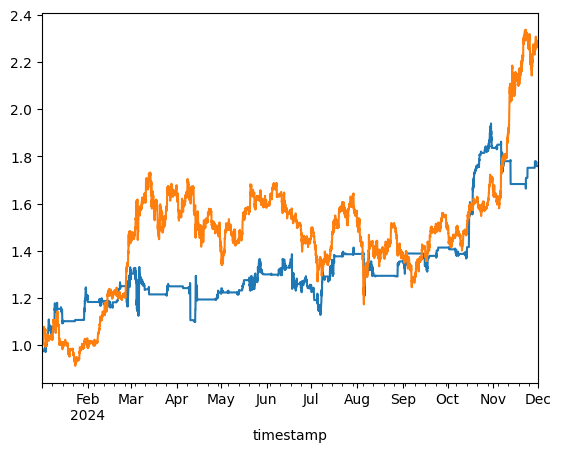

In [278]:
np.exp(strategy_return["ret"].cumsum()).plot()
np.exp(log_returns["BTCUSDT"].cumsum()).plot()
np.exp(strategy_return["ret"].cumsum())[-1]

In [279]:
strategy_log_returns = strategy_return["ret"].values

sharpe = np.sqrt(365*24)*np.mean(strategy_log_returns)/np.std(strategy_log_returns)
sharpe_btc = np.sqrt(365*24)*np.mean(log_returns["BTCUSDT"])/np.std(log_returns["BTCUSDT"])

sharpe

np.float64(1.4262322532027254)

In [268]:
log_returns

,ADAUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,ETHUSDT,XRPUSDT
timestamp,,,,,,
2024-01-01 01:00:00,0.007332,0.002859,0.003251,0.003667,0.003570,0.003726
2024-01-01 02:00:00,-0.004660,-0.014053,-0.000762,-0.004001,-0.004655,-0.005025
2024-01-01 03:00:00,-0.006527,-0.005483,-0.005903,-0.006592,-0.008413,-0.003908
2024-01-01 04:00:00,-0.000504,0.000000,0.001640,-0.001234,0.002521,-0.002286
2024-01-01 05:00:00,-0.005390,-0.001618,-0.003922,-0.001123,-0.001607,-0.004753
...,...,...,...,...,...,...
2024-11-30 20:00:00,0.003035,0.003506,-0.000533,0.004777,0.006069,-0.004326
2024-11-30 21:00:00,0.001560,0.000289,-0.001816,-0.000350,0.002201,0.015477
2024-11-30 22:00:00,-0.012918,-0.003017,-0.003373,-0.015568,-0.003083,-0.004539
